## Accessing NEX-GDDP-CMIP6 data with the Planetary Computer STAC API

The [NEX-GDDP-CMIP6 dataset](https://planetarycomputer.microsoft.com/dataset/nasa-nex-gddp-cmip6) offers global downscaled climate scenarios derived from the General Circulation Model (GCM) runs conducted under the Coupled Model Intercomparison Project Phase 6 (CMIP6) and across two of the four “Tier 1” greenhouse gas emissions scenarios known as Shared Socioeconomic Pathways (SSPs). The purpose of this dataset is to provide a set of global, high resolution, bias-corrected climate change projections that can be used to evaluate climate change impacts on processes that are sensitive to finer-scale climate gradients and the effects of local topography on climate conditions.

This dataset uses a Bias-Correction Spatial Disaggregation method to downscale the original General Circulation Model runs to the finer 0.25° resolution. See the [tech note](https://www.nccs.nasa.gov/sites/default/files/NEX-GDDP-CMIP6-Tech_Note.pdf) from the [product homepage](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6) for more details.

The NEX-GDDP-CMIP6 files are stored as NetCDF in Azure Blob Storage. Each STAC Item in this collection describes a single year for one scenario for one model.

In [1]:
import planetary_computer
import xarray as xr
import fsspec
import pystac_client

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1/"
)

### Understanding the metadata

The STAC metadata on the Collection, items, and assets provide information on what data is available.

In [2]:
collection = catalog.get_collection("nasa-nex-gddp-cmip6")

As usual, the collection object contains information about the dataset including its spatio-temporal extent, license, and so on. We also have information unique to CMIP6. The collection is organized by `{model}-{scenario}-{year}`: there's is a single STAC item for each (valid) combination (data is not available for some; see Table 1 in the [tech note](https://www.nccs.nasa.gov/sites/default/files/NEX-GDDP-CMIP6-Tech_Note.pdf) for more). The valid values for each of these are stored in the collection's summaries:

In [3]:
# List the models. There are ~30 in total.
collection.summaries.get_list("cmip6:model")[:5]

['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM']

In [4]:
# List the scenarios
collection.summaries.get_list("cmip6:scenario")

['historical', 'ssp245', 'ssp585']

The "historical" scenario covers the years 1950 - 2014 (inclusive). The "ssp245" and "ssp585" cover the years 2015 - 2100 (inclusive).

Each item includes a handful of assets, one per variable, where each asset is a single NetCDF file with the data for that variable for that model-scenario-year.

In [5]:
# list the variables
collection.summaries.get_list("cmip6:variable")

['hurs', 'huss', 'pr', 'rlds', 'rsds', 'sfcWind', 'tas', 'tasmax', 'tasmin']

### Querying the STAC API

Each STAC item covers the same spatial region, so when using the STAC API you're likely filtering on some combination of time, model, and scenario. For example, we can get the STAC items for the "ACCESS-CM2" model for the years 1950 - 2000.

In [6]:
search = catalog.search(
    collections=["nasa-nex-gddp-cmip6"],
    datetime="1950/2000",
    query={"cmip6:model": {"eq": "ACCESS-CM2"}},
)
items = search.get_all_items()
len(items)

51

Eacah of these items has nine assets, one per variable, which point to the NetCDF files in Azure Blob Storage:

In [7]:
item = items[0]
item.assets

{'pr': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/pr/pr_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc>,
 'tas': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/tas/tas_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc>,
 'hurs': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc>,
 'huss': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/huss/huss_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc>,
 'rlds': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/rlds/rlds_day_ACCESS-CM2_historical_r1i1p1f1_gn_2000.nc>,
 'rsds': <Asset href=https://nasagddp.blob.core.windows.net/nex-gddp-cmip6/NEX/GDDP-CMIP6/ACCESS-CM2/historical/r1

### Loading data

Once you have a STAC item or items, you can load the data directly from Blob Storage using xarray. As usual, we `sign` the item, to ensure that the URLs include a read-only SAS token. See [Acessing data from blob storage](https://planetarycomputer.microsoft.com/docs/quickstarts/storage/) for more.

In [8]:
signed_item = planetary_computer.sign(item)

hurs = xr.open_dataset(fsspec.open(signed_item.assets["hurs"].href).open())
hurs

<xarray.Dataset>
Dimensions:  (time: 366, lat: 600, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    hurs     (time, lat, lon) float32 ...
Attributes: (12/22)
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T13:59:35.374080+00:00
    frequency:             day
    institution:           NASA Earth Exchange, NASA Ames Research Center, Mo...
    ...                    ...
    history:               2021-10-04T13:59:35.374080+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       ACCESS-CM2
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0

Or you can use `xarray.open_mfdataset` to load all the variables for an item, which will combine each of the varaibles.

In [9]:
%%time
ds = xr.open_mfdataset(
    [fsspec.open(asset.href).open() for asset in signed_item.assets.values()]
)

CPU times: user 1.07 s, sys: 226 ms, total: 1.3 s
Wall time: 4.23 s


*Note that opening all those variables is relatively slow. See [below](#Using-a-Reference-File) for an alternative.*

We can plot all the variables for a single day with xarray, matplotlib, and cartopy.

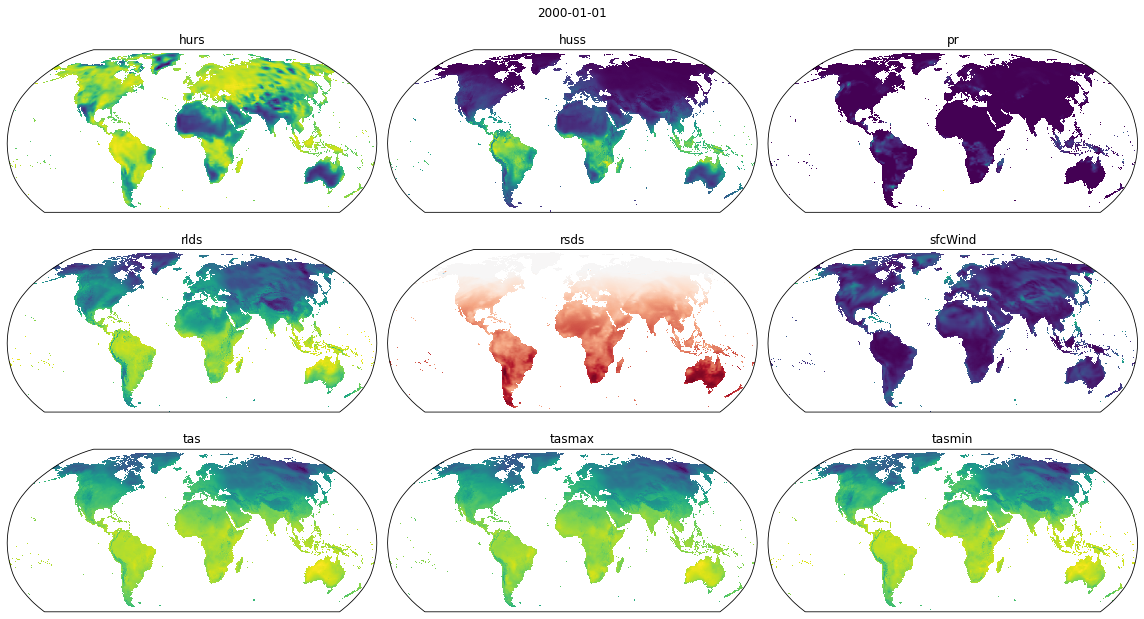

In [10]:
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings("ignore", message="__len__")
warnings.filterwarnings("ignore", message="Iteration")


fig, axes = plt.subplots(
    figsize=(16, 9),
    ncols=3,
    nrows=3,
    subplot_kw=dict(projection=ccrs.Robinson()),
    sharex=True,
    sharey=True,
)

day = ds.isel(time=0)

for i, (v, data) in enumerate(day.data_vars.items()):
    ax = axes.ravel()[i]
    r = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)
    ax.set(title=v)

fig.suptitle(pd.to_datetime(day.time.data).strftime("%Y-%m-%d"))
plt.tight_layout()

#### Creating a timeseries

Each STAC item represents a single year. You can also use `xarray.open_mfdataset` to concatenate data for multiple years into a timeseries.

In [11]:
signed_items = [planetary_computer.sign(item) for item in items]

In [12]:
%%time
ts = xr.open_mfdataset(
    [fsspec.open(item.assets["hurs"].href).open() for item in signed_items],
)
ts["hurs"]

CPU times: user 5.66 s, sys: 682 ms, total: 6.34 s
Wall time: 21.5 s


<xarray.DataArray 'hurs' (time: 18628, lat: 600, lon: 1440)>
dask.array<concatenate, shape=(18628, 600, 1440), dtype=float32, chunksize=(366, 600, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T12:00:00 ... 2000-12-31T12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    standard_name:  relative_humidity
    long_name:      Near-Surface Relative Humidity
    units:          %
    comment:        The relative humidity with respect to liquid water for T>...
    cell_methods:   area: time: mean
    cell_measures:  area: areacella

#### Using a Reference File

*Note: the approach described here is experimental and may change without warning.*

In the previous section, we created a single `xarray.Dataset` from many NetCDF files (either many variables, or a timeseries for a single variable). Reading the metadata of a NetCDF / HDF5 file over the network is somewhat slow, making the `open_mfdataset` operation take about 20-30 seconds, *just to read the metadata*.

So in addition to the NetCDF files, we provide a **reference file** which stores the positions of each variable in each NetCDF file's binary stream. This reference file can be opened with `fsspec` and `zarr` and used normally with xarray.

In [13]:
import requests

references = requests.get(collection.assets["ACCESS-CM2.historical"].href).json()

This reference file contains links to the original NetCDF files, along with the positions and lengths of each variable in the files. As usual, we need to sign the URLs to include short-lived tokens so that we can read the data.

In [14]:
# TODO: update planetary computer
for k, v in references["templates"].items():
    references["templates"][k] = planetary_computer.sign(v)

We can pass that set of references to fsspec's `ReferenceFileSystem`:

In [15]:
reference_filesystem = fsspec.filesystem("reference", fo=references)

And (quickly!) open the referenced files with xarray and Zarr.

In [16]:
%%time
ds = xr.open_dataset(
    reference_filesystem.get_mapper("/"),
    engine="zarr",
    backend_kwargs={"consolidated": False},
    chunks={},
)
ds

CPU times: user 1.84 s, sys: 52.1 ms, total: 1.89 s
Wall time: 1.97 s


<xarray.Dataset>
Dimensions:  (time: 23741, lat: 600, lon: 1440)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * time     (time) datetime64[us] 1950-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rlds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    rsds     (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    sfcWind  (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(1, 600, 1440), meta=np.ndarray>
Attributes: (12/22)
    Conventions:           CF-1.7
    activity:              NEX-GDDP-CMIP6
    cmip6_institution_id:  CSIRO-ARCCSS
    cmip6_license:         CC-BY-SA 4.0
    cmip6_source_id:       ACCESS-CM2
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    ...                    ...
    scenario:              historical
    source:                BCSD
    title:                 ACCESS-CM2, r1i1p1f1, historical, global downscale...
    tracking_id:           16d27564-470f-41ea-8077-f4cc3efa5bfe
    variant_label:         r1i1p1f1
    version:               1.0

This reference file system includes all the variables for all the years covered by the specific scenario.

### Next Steps

For more on the NEX-GDDP-CMIP6 dataset, visit the [dataset's homepage](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6). If you're working with large subsets of this data, you might want to [scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/).